# Semi Synthetic Experiments

Analyze the performance of various algorithms to solve the joint matching + activity task, when the number of volunteers is large and structured

In [20]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import json 
import argparse 
import sys
import secrets

In [88]:
from rmab.simulator import RMABSimulator, generate_random_context
from rmab.omniscient_policies import *
from rmab.mcts_policies import full_mcts_contextual_policy
from rmab.fr_dynamics import get_all_transitions
from rmab.utils import get_save_path, delete_duplicate_results

In [23]:
is_jupyter = 'ipykernel' in sys.modules

In [210]:
if is_jupyter: 
    seed        = 42
    n_arms      = 2
    volunteers_per_arm = 5
    budget      = 2
    discount    = 0.9
    alpha       = 3 
    n_episodes  = 125 
    episode_len = 20 
    n_epochs    = 5
    save_with_date = False 
    TIME_PER_RUN = 0.01 * 1000
    lamb = 0/(n_arms*volunteers_per_arm)
    prob_distro = 'normal'
    context_dim = 2
else:
    parser = argparse.ArgumentParser()
    parser.add_argument('--n_arms',         '-N', help='num beneficiaries (arms)', type=int, default=2)
    parser.add_argument('--volunteers_per_arm',         '-V', help='volunteers per arm', type=int, default=5)
    parser.add_argument('--episode_len',    '-H', help='episode length', type=int, default=20)
    parser.add_argument('--n_episodes',     '-T', help='num episodes', type=int, default=30)
    parser.add_argument('--budget',         '-B', help='budget', type=int, default=3)
    parser.add_argument('--n_epochs',       '-E', help='number of epochs (num_repeats)', type=int, default=10)
    parser.add_argument('--discount',       '-d', help='discount factor', type=float, default=0.9)
    parser.add_argument('--alpha',          '-a', help='alpha: for conf radius', type=float, default=3)
    parser.add_argument('--lamb',          '-l', help='lambda for matching-engagement tradeoff', type=float, default=1)
    parser.add_argument('--seed',           '-s', help='random seed', type=int, default=42)
    parser.add_argument('--prob_distro',           '-p', help='which prob distro [uniform,uniform_small,uniform_large,normal]', type=str, default='uniform')
    parser.add_argument('--time_per_run',      '-t', help='time per MCTS run', type=float, default=.01*1000)
    parser.add_argument('--use_date', action='store_true')
    parser.add_argument('--context_dim',           '-c', help='Size of the context dim, integer', type=int, default=2)

    args = parser.parse_args()

    n_arms      = args.n_arms
    volunteers_per_arm = args.volunteers_per_arm
    budget      = args.budget
    discount    = args.discount
    alpha       = args.alpha 
    seed        = args.seed
    n_episodes  = args.n_episodes
    episode_len = args.episode_len
    n_epochs    = args.n_epochs
    lamb = args.lamb /(volunteers_per_arm*n_arms)
    save_with_date = args.use_date
    TIME_PER_RUN = args.time_per_run
    prob_distro = args.prob_distro
    context_dim = args.context_dim 

save_name = secrets.token_hex(4)  

In [211]:
n_states = 2
n_actions = 2

In [212]:
all_population_size = 100 # number of random arms to generate
all_transitions = get_all_transitions(all_population_size)

In [213]:
all_transitions = np.zeros((all_population_size,2,2,2))
all_transitions[:,:,1,1] = 1
all_transitions[:,:,0,0] = 1

In [214]:
random.seed(seed)
np.random.seed(seed)

In [215]:
all_features = np.arange(all_population_size)

In [216]:
match_probabilities = [generate_random_context(context_dim)*(0.8+random.random()*0.2) for i in range(all_population_size * volunteers_per_arm)]

In [217]:
def get_match_probability(context,arm_context):
    return arm_context.dot(context)**2

In [218]:
np.random.seed(seed)
random.seed(seed)
simulator = RMABSimulator(all_population_size, all_features, all_transitions,
            n_arms, volunteers_per_arm, episode_len, n_epochs, n_episodes, budget, discount,number_states=n_states, match_probability_list=match_probabilities,reward_style='match',TIME_PER_RUN=TIME_PER_RUN,match_function=get_match_probability,context_dim=context_dim)

cohort [83 53]
cohort [61  9]
cohort [64 32]
cohort [34 69]
cohort [44  3]


In [219]:
results = {}
results['parameters'] = {'seed'      : seed,
        'n_arms'    : n_arms,
        'volunteers_per_arm': volunteers_per_arm, 
        'budget'    : budget,
        'discount'  : discount, 
        'alpha'     : alpha, 
        'n_episodes': n_episodes, 
        'episode_len': episode_len, 
        'n_epochs'  : n_epochs, 
        'lamb': lamb,
        'time_per_run': TIME_PER_RUN, 
        'prob_distro': prob_distro} 

## Index Policies

In [220]:
policy = greedy_policy_contextual
name = "greedy"
greedy_match, greedy_active_rate = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,should_train=True,test_T=1000)
time_greedy = simulator.time_taken
greedy_discounted_reward = get_discounted_reward(greedy_match,greedy_active_rate,discount,lamb)

print(greedy_discounted_reward)

results['{}_reward'.format(name)] = greedy_discounted_reward
results['{}_match'.format(name)] = np.mean(greedy_match) 
results['{}_active'.format(name)] = np.mean(greedy_active_rate)
results['{}_time'.format(name)] = time_greedy 

instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9


instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
instance 0, ep 30
instance 0, ep 31
instance 0, ep 32
instance 0, ep 33
instance 0, ep 34
instance 0, ep 35
instance 0, ep 36
instance 0, ep 37
instance 0, ep 38
instance 0, ep 39
instance 0, ep 40
instance 0, ep 41
instance 0, ep 42
instance 0, ep 43
instance 0, ep 44
instance 0, ep 45
instance 0, ep 46
instance 0, ep 47
instance 0, ep 48
instance 0, ep 49
instance 0, ep 50
instance 0, ep 51
instance 0, ep 52
instance 0, ep 53
instance 0, ep 54
instance 0, ep 55
instance 0, ep 56
instance 0, ep 57
instance 0, ep 58
instance 0, ep 59
instance 0, ep 60
instance 0, ep 61
instance 0, ep 62
instance 0, ep 63
instance 0, ep 64
instance 0

In [221]:
policy = random_policy
name = "random"
random_match, random_active_rate = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,should_train=True,test_T=1000)
time_random = simulator.time_taken
random_discounted_reward = get_discounted_reward(random_match,random_active_rate,discount,lamb)

print(random_discounted_reward)

results['{}_reward'.format(name)] = random_discounted_reward
results['{}_match'.format(name)] = np.mean(random_match) 
results['{}_active'.format(name)] = np.mean(random_active_rate)
results['{}_time'.format(name)] = time_random 

instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13


instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
instance 0, ep 30
instance 0, ep 31
instance 0, ep 32
instance 0, ep 33
instance 0, ep 34
instance 0, ep 35
instance 0, ep 36
instance 0, ep 37
instance 0, ep 38
instance 0, ep 39
instance 0, ep 40
instance 0, ep 41
instance 0, ep 42
instance 0, ep 43
instance 0, ep 44
instance 0, ep 45
instance 0, ep 46
instance 0, ep 47
instance 0, ep 48
instance 0, ep 49
instance 0, ep 50
instance 0, ep 51
instance 0, ep 52
instance 0, ep 53
instance 0, ep 54
instance 0, ep 55
instance 0, ep 56
instance 0, ep 57
instance 0, ep 58
instance 0, ep 59
instance 0, ep 60
instance 0, ep 61
instance 0, ep 62
instance 0, ep 63
instance 0, ep 64
instance 0, ep 65
instance 0, ep 66
instance 0, ep 67
instance 0, ep 68
instance 0

In [222]:
policy = whittle_activity_policy
name = "whittle_engagement"
whittle_activity_match, whittle_activity_active_rate = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,should_train=True,test_T=1000)
time_whittle_activity = simulator.time_taken
whittle_activity_discounted_reward = get_discounted_reward(whittle_activity_match,whittle_activity_active_rate,discount,lamb)

print(whittle_activity_discounted_reward)

results['{}_reward'.format(name)] = whittle_activity_discounted_reward
results['{}_match'.format(name)] = np.mean(whittle_activity_match) 
results['{}_active'.format(name)] = np.mean(whittle_activity_active_rate)
results['{}_time'.format(name)] = time_whittle_activity 

instance 0, ep 1


instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
instance 0, ep 30
instance 0, ep 31
instance 0, ep 32
instance 0, ep 33
instance 0, ep 34
instance 0, ep 35
instance 0, ep 36
instance 0, ep 37
instance 0, ep 38
instance 0, ep 39
instance 0, ep 40
instance 0, ep 41
instance 0, ep 42
instance 0, ep 43
instance 0, ep 44
instance 0, ep 45
instance 0, ep 46
instance 0, ep 47
instance 0, ep 48
instance 0, ep 49
instance 0, ep 50
instance 0, ep 51
instance 0, ep 52
instance 0, ep 53
instance 0, ep 54
instance 0, ep 55
instance 0, ep 56
instance 0, ep 57


In [223]:
policy = whittle_policy_contextual
name = "linear_whittle"
whittle_match, whittle_active_rate = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,should_train=True,test_T=1000)
time_whittle = simulator.time_taken
whittle_discounted_reward = get_discounted_reward(whittle_match,whittle_active_rate,discount,lamb)

print(whittle_discounted_reward)

results['{}_reward'.format(name)] = whittle_discounted_reward
results['{}_match'.format(name)] = np.mean(whittle_match) 
results['{}_active'.format(name)] = np.mean(whittle_active_rate)
results['{}_time'.format(name)] = time_whittle 

instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
instance 0, ep 30
instance 0, ep 31
instance 0, ep 32
instance 0, ep 33
instance 0, ep 34
instance 0, ep 35
instance 0, ep 36
instance 0, ep 37
instance 0, ep 38
instance 0, ep 39
instance 0, ep 40
instance 0, ep 41
instance 0, ep 42
instance 0, ep 43
instance 0, ep 44
instance 0, ep 45
instance 0, ep 46
instance 0, ep 47
instance 0, ep 48
instance 0, ep 49
instance 0, ep 50
instance 0, ep 51
instance 0, ep 52
instance 0, ep 53
instance 0, ep 54
instance 0, ep 55
instance 0, ep 56
i

In [224]:
policy = whittle_greedy_contextual_policy
name = "greedy_whittle"
whittle_greedy_match, whittle_greedy_active_rate = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,should_train=True,test_T=1000)
time_whittle_greedy = simulator.time_taken
whittle_greedy_discounted_reward = get_discounted_reward(whittle_greedy_match,whittle_greedy_active_rate,discount,lamb)

print(whittle_greedy_discounted_reward)

results['{}_reward'.format(name)] = whittle_greedy_discounted_reward
results['{}_match'.format(name)] = np.mean(whittle_greedy_match) 
results['{}_active'.format(name)] = np.mean(whittle_greedy_active_rate)
results['{}_time'.format(name)] = time_whittle_greedy 

instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
instance 0, ep 30
instance 0, ep 31
instance 0, ep 32
instance 0, ep 33
instance 0, ep 34
instance 0, ep 35
instance 0, ep 36
instance 0, ep 37
instance 0, ep 38
instance 0, ep 39
instance 0, ep 40
instance 0, ep 41
instance 0, ep 42
instance 0, ep 43
instance 0, ep 44
instance 0, ep 45
instance 0, ep 46
instance 0, ep 47
instance 0, ep 48
instance 0, ep 49
instance 0, ep 50
instance 0, ep 51
instance 0, ep 52
instance 0, ep 53
instance 0, ep 54
instance 0, ep 55
instance 0, ep 56
i

KeyboardInterrupt: 

In [ ]:
policy = shapley_whittle_contextual_policy
name = "shapley_whittle"
whittle_shapley_match, whittle_shapley_active_rate = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,should_train=True,test_T=1000)
time_whittle_shapley = simulator.time_taken
whittle_shapley_discounted_reward = get_discounted_reward(whittle_shapley_match,whittle_shapley_active_rate,discount,lamb)

print(whittle_shapley_discounted_reward)

results['{}_reward'.format(name)] = whittle_shapley_discounted_reward
results['{}_match'.format(name)] = np.mean(whittle_shapley_match) 
results['{}_active'.format(name)] = np.mean(whittle_shapley_active_rate)
results['{}_time'.format(name)] = time_whittle_shapley 

instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
instance 0, ep 30
instance 0, ep 31
instance 0, ep 32
instance 0, ep 33
instance 0, ep 34
instance 0, ep 35
instance 0, ep 36
instance 0, ep 37
instance 0, ep 38
instance 0, ep 39
instance 0, ep 40
instance 0, ep 41
instance 0, ep 42
instance 0, ep 43
instance 0, ep 44
instance 0, ep 45
instance 0, ep 46
instance 0, ep 47
instance 0, ep 48
instance 0, ep 49
instance 0, ep 50
instance 0, ep 51
instance 0, ep 52
instance 0, ep 53
instance 0, ep 54
instance 0, ep 55
instance 0, ep 56
i

In [ ]:
policy = contextual_future_policy
name = "future_context"
future_match, future_active_rate = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,should_train=True,test_T=1000)
time_future = simulator.time_taken
future_discounted_reward = get_discounted_reward(future_match,future_active_rate,discount,lamb)

print(future_discounted_reward)

results['{}_reward'.format(name)] = future_discounted_reward
results['{}_match'.format(name)] = np.mean(future_match) 
results['{}_active'.format(name)] = np.mean(future_active_rate)
results['{}_time'.format(name)] = time_future 

instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8


instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
instance 0, ep 30
instance 0, ep 31
instance 0, ep 32
instance 0, ep 33
instance 0, ep 34
instance 0, ep 35
instance 0, ep 36
instance 0, ep 37
instance 0, ep 38
instance 0, ep 39
instance 0, ep 40
instance 0, ep 41
instance 0, ep 42
instance 0, ep 43
instance 0, ep 44
instance 0, ep 45
instance 0, ep 46
instance 0, ep 47
instance 0, ep 48
instance 0, ep 49
instance 0, ep 50
instance 0, ep 51
instance 0, ep 52
instance 0, ep 53
instance 0, ep 54
instance 0, ep 55
instance 0, ep 56
instance 0, ep 57
instance 0, ep 58
instance 0, ep 59
instance 0, ep 60
instance 0, ep 61
instance 0, ep 62
instance 0, ep 63
instance 0,

In [ ]:
simulator.mcts_test_iterations = 0
simulator.mcts_train_iterations = 20

policy = full_mcts_contextual_policy
name = "mcts"
mcts_match, mcts_active_rate,memory = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,get_memory=True,should_train=True,test_T=1000)
time_mcts = simulator.time_taken
mcts_discounted_reward = get_discounted_reward(mcts_match,mcts_active_rate,discount,lamb)

print(mcts_discounted_reward)

results['{}_reward'.format(name)] = mcts_discounted_reward
results['{}_match'.format(name)] = np.mean(mcts_match) 
results['{}_active'.format(name)] = np.mean(mcts_active_rate)
results['{}_time'.format(name)] = time_mcts 

instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
instance 0, ep 30
instance 0, ep 31
instance 0, ep 32
instance 0, ep 33
instance 0, ep 34
instance 0, ep 35
instance 0, ep 36
instance 0, ep 37
instance 0, ep 38
instance 0, ep 39
instance 0, ep 40
instance 0, ep 41
instance 0, ep 42
instance 0, ep 43
instance 0, ep 44
instance 0, ep 45
instance 0, ep 46
instance 0, ep 47
instance 0, ep 48
instance 0, ep 49
instance 0, ep 50
instance 0, ep 51
instance 0, ep 52
instance 0, ep 53
instance 0, ep 54
instance 0, ep 55
instance 0, ep 56
i

In [ ]:
if is_jupyter:
    def plot_sliding_window(data):
        return [np.mean(data[i:i+100]) for i in range(len(data)-100)]
    policy_loss_1 = memory[-6]
    value_loss_1 = memory[-10]

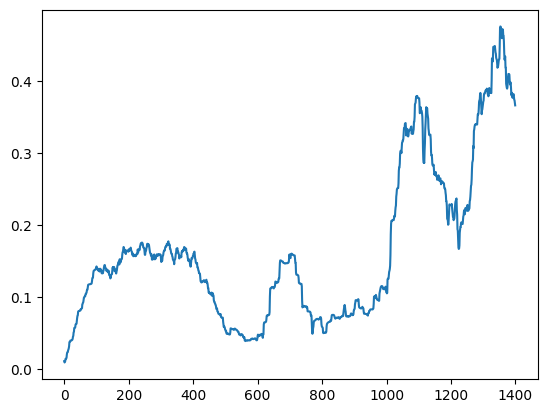

In [206]:
if is_jupyter:  
    plt.plot(plot_sliding_window(value_loss_1))

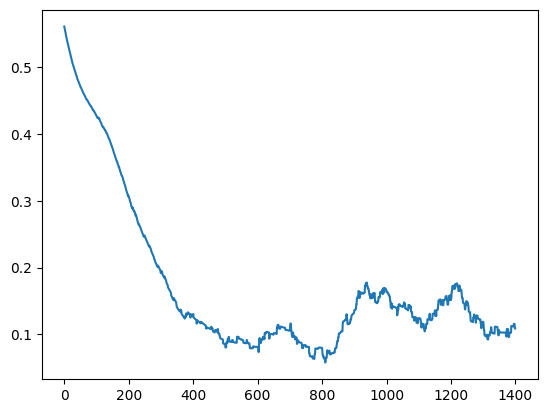

In [185]:
if is_jupyter:
    plt.plot(plot_sliding_window(policy_loss_1))

## Write Data

In [51]:
save_path = get_save_path('contextual',save_name,seed,use_date=save_with_date)

In [132]:
delete_duplicate_results('contextual',"",results)

In [53]:
json.dump(results,open('../results/'+save_path,'w'))